# AI Image Recognition of Sign Language and Sentiment Analysis using NLP

For persons who have hearing loss and trouble communicating, **Sign language** is vital. We employ this project to figure out what they're trying to convey. In this work we will classify images of static letter hand posture using **Neural Networks** and thereby using a **Text Classification Model** to analyse the emotions of handicapped people.

#### Importing the required libraries

In [14]:
import cv2

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os

import glob

from pathlib import Path

from tensorflow import keras
from keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import pickle
from PIL import Image


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tqdm._tqdm_notebook import tqdm_notebook
import text_hammer as th
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Dense,Input,Dropout, GlobalMaxPool1D
from sklearn.metrics import classification_report
import gc

import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

#### Training Model for Sign Language - Image classicfication

In [2]:
# Defining function for getting labels of an image
# Converting folder to dataframe of images' paths & labels
def get_labels(path, allowed_extension="jpg"):
        global Path
        images_dir = Path(path)
        
        filepaths = pd.Series((images_dir.glob(fr'**/*.{allowed_extension}'))).astype(str)
        filepaths.name = "path"
        
        labels = filepaths.str.split("/")[:].str[-2]
        labels.name = "label"

        # Concatenate filepaths and labels
        df = pd.concat([filepaths, labels], axis=1)

        # Shuffle the DataFrame and reset index
        df = df.sample(frac=1).reset_index(drop = True)
        return df

# Defining function to read image
def get_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
    
# Defining functions to visualize sample images
def visualize_images(datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)
    
    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    images = filepaths.apply(get_image).reset_index(drop=True)
    
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(labels[sample_index])
            ax[i,j].set_axis_off()
    plt.show()
    

# Defining the function to pre process the image
def process(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = tf.keras.applications.mobilenet.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

In [3]:
# fetching the path of training data from the local
path = os. getcwd() + '/asl_alphabet_train'

# creating a new data frame for the training data
dataset = get_labels(path)
print(dataset)

                                                    path  label
0      /Users/kakiyeswanth/Documents/data-and-comp-sc...      R
1      /Users/kakiyeswanth/Documents/data-and-comp-sc...      C
2      /Users/kakiyeswanth/Documents/data-and-comp-sc...      G
3      /Users/kakiyeswanth/Documents/data-and-comp-sc...      E
4      /Users/kakiyeswanth/Documents/data-and-comp-sc...      D
...                                                  ...    ...
86995  /Users/kakiyeswanth/Documents/data-and-comp-sc...      B
86996  /Users/kakiyeswanth/Documents/data-and-comp-sc...      F
86997  /Users/kakiyeswanth/Documents/data-and-comp-sc...      X
86998  /Users/kakiyeswanth/Documents/data-and-comp-sc...  space
86999  /Users/kakiyeswanth/Documents/data-and-comp-sc...      O

[87000 rows x 2 columns]


In [4]:
# Dividing the training data into 80% training and 20% test data
msk = np.random.rand(len(dataset)) < 0.8
trainData = dataset[msk]
testData = dataset[~msk]
print(len(trainData))
print(len(testData))

69494
17506


In [5]:
# Printing the count of classes in the training data
print("Classes counts")
counts = trainData.iloc[:,1].value_counts().sort_index()
print(counts.head(counts.shape[0]))
print(f"\n\nDataset size = {counts.sum()} samples")

Classes counts
A          2405
B          2410
C          2404
D          2407
E          2389
F          2411
G          2365
H          2390
I          2399
J          2404
K          2387
L          2405
M          2403
N          2423
O          2370
P          2395
Q          2374
R          2420
S          2415
T          2383
U          2370
V          2375
W          2419
X          2402
Y          2386
Z          2361
del        2385
nothing    2436
space      2401
Name: label, dtype: int64


Dataset size = 69494 samples


In [6]:
# Preprocess training data using Keras Image Data Generator
# Splitting the train data into 80% train and 20% validation data
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    validation_split=0.2,
    horizontal_flip = True,
    brightness_range=(0.75, 1.3),
    zoom_range=0.2
)

# Processing the training images
train_images = train_generator.flow_from_dataframe(
    dataframe=trainData,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='training'
)

# Processing the validation images
val_images = train_generator.flow_from_dataframe(
    dataframe=trainData,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='validation'
)


Found 55596 validated image filenames belonging to 29 classes.
Found 13898 validated image filenames belonging to 29 classes.


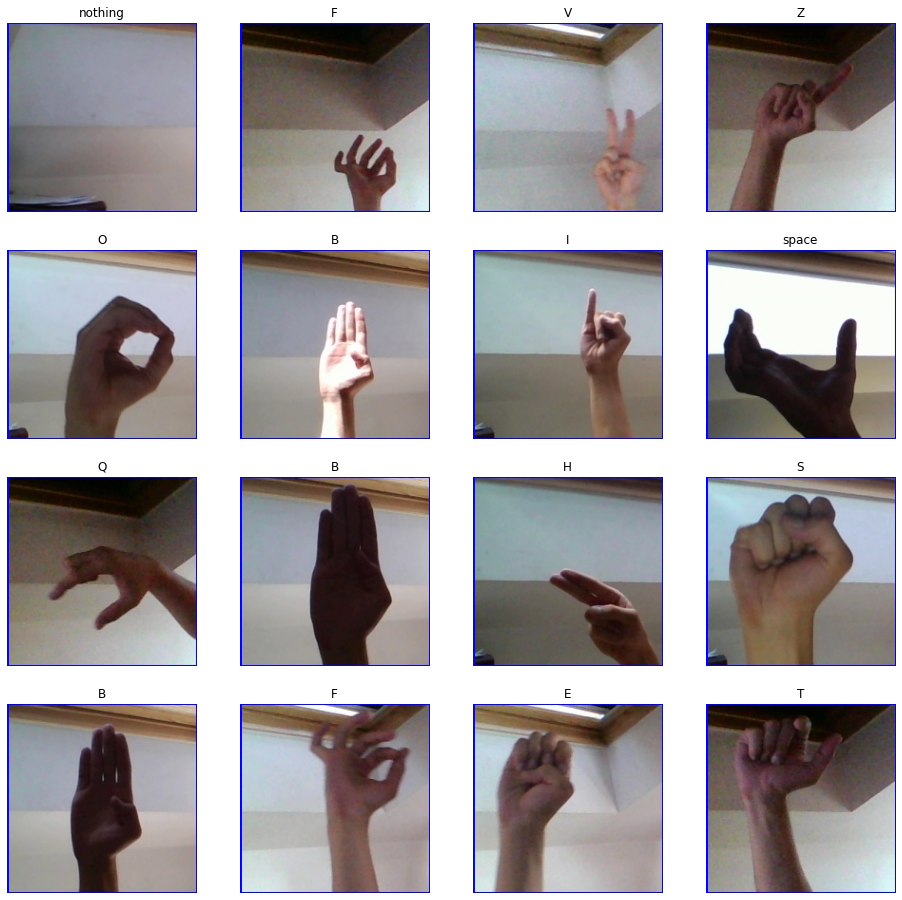

In [7]:
visualize_images(train_images)

In [8]:
# Defining pretrained model of MobileNet Architecture
pretrainedModel = tf.keras.applications.MobileNet(
    input_shape=(224, 224, 3),
     include_top=False,
     weights='imagenet',
     pooling='avg'
)
pretrainedModel.trainable = False

inputs = pretrainedModel.input

# Defining two input layers with batch size of 128 and relu activation function
x = tf.keras.layers.Dense(128, activation='relu')(pretrainedModel.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

# Defining output layer with batch size of 64 and softmax regression activation function
outputs = tf.keras.layers.Dense(29, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Defining Adam optimizer in the model with learning rate 0.005
optimizer_adam = tf.keras.optimizers.Adam(learning_rate = 0.005)


In [ ]:
# Compiling the defined model
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Fitting the model
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=2,
 )

In [ ]:

# Plotting the training and validation Accuracy

%matplotlib inline
acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])
loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

epochs = np.arange(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.scatter(epochs[val_acc.argmax()], val_acc.max(), color='green', s=70)
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.scatter(epochs[val_loss.argmin()], val_loss.min(), color='green', s=70)
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Training Model for Emotion Detection

In [ ]:
# reading test train and validatio dataset from .txt and dividing into columns as Text and Emotion
df_test = pd.read_csv('Emotiontest.txt', names=['Text', 'Emotion'], sep=';',header=None,encoding='utf-8')
df_train = pd.read_csv('Emotiontrain.txt', names=['Text', 'Emotion'], sep=';',header=None,encoding='utf-8')
df_valid = pd.read_csv('Emotionval.txt', names=['Text', 'Emotion'], sep=';',header=None,encoding='utf-8')

In [ ]:
#combining all 3 into a single dataframe
df_full = pd.concat([df_train,df_test,df_valid],axis=0)

In [ ]:
#preprocess function for the columns
tqdm_notebook.pandas()
def text_preprocessing(df, col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x:th.cont_exp(x))
    df[column] = df[column].progress_apply(lambda x:th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x:th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x:th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x:th.remove_accented_chars(x))
    return df

In [ ]:
#preprocess the Text column in the datframe with test, train and validation
df_cleaned = text_preprocessing(df_full, 'Text')

In [ ]:
#convert the emotion column into a category with 6 levels
df_cleaned['Emotion'] = df_cleaned.Emotion.astype('category')
print(df_cleaned.Emotion.unique())
#create a map with the same emotions
dic = {'anger':0,'fear':1,'joy':2,'love':3,'sadness':4,'suprise':5}
dic1 = list(dic.keys())
#map emotion as a category to the categorised column
df_cleaned['Emotion']=df_cleaned.Emotion.cat.codes
df_cleaned.head()

In [ ]:
#split the data back into test and train 
data_train,data_test=train_test_split(df_cleaned,test_size=0.3,random_state=42,stratify=df_cleaned.Emotion)

In [ ]:
#get the url for tokenising the model
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [ ]:
#import tranformers and  tokenisers from bert-base-cased 
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

In [ ]:
#tokenise the test and train data
x_train = tokenizer(text =data_train.Text.tolist(),
                  padding='max_length',
                    truncation=True,
                    max_length=130,
                    return_tensors="tf")
x_test =tokenizer(text = data_test.Text.tolist(),
                  padding='max_length',
                    truncation=True,
                    max_length=130,
                    return_tensors="tf")

In [ ]:
#construct the bert DNN model with relu and sigmoid functions
max_len =130

input_ids = Input(shape=(max_len), dtype=tf.int32, name='input_ids')
input_mask = Input(shape=(max_len), dtype=tf.int32, name='attention_mask')

embeddings = bert(input_ids, attention_mask=input_mask)[0]
out = GlobalMaxPool1D()(embeddings)
out = Dense(256, activation='relu')(out)
out = Dropout(0.3)(out)
out = Dense(256, activation='relu')(out)
y = Dense(6, activation='sigmoid')(out)

nlp_model = tf.keras.Model(inputs=[input_ids,input_mask], outputs=y)
nlp_model.layers[2].trainable = True
nlp_model.summary()

In [ ]:
#use adam optimiser to optimise the model with categoricalcrossentropy
optimizer = Adam(learning_rate=5e-5, 
                epsilon=1e-08,
                decay=0.01,
                clipnorm=1.0)
loss = CategoricalCrossentropy()
metric = CategoricalAccuracy('balanced_accuracy')
nlp_model.compile(optimizer=optimizer,loss=loss,metrics=metric)

In [ ]:
#construct the bert DNN model with relu and sigmoid functions
max_len =130

input_ids = Input(shape=(max_len), dtype=tf.int32, name='input_ids')
input_mask = Input(shape=(max_len), dtype=tf.int32, name='attention_mask')

embeddings = bert(input_ids, attention_mask=input_mask)[0]
out = GlobalMaxPool1D()(embeddings)
out = Dense(256, activation='relu')(out)
out = Dropout(0.3)(out)
out = Dense(256, activation='relu')(out)
y = Dense(6, activation='sigmoid')(out)

nlp_model = tf.keras.Model(inputs=[input_ids,input_mask], outputs=y)
nlp_model.layers[2].trainable = True
nlp_model.summary()

In [ ]:
#to collect the intermediate values and plot the convergence
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)
#avoid memory outage
gc.collect()

In [ ]:
nlp_model.fit(
    x={'input_ids':x_train['input_ids'], 'attention_mask':x_train['attention_mask']},
    y=to_categorical(data_train.Emotion),
    epochs=4, 
    batch_size=36)
nlp_model.save_weights('emotion_predictor1.h5')
gc.collect()

#### Testing Model for Sign Language

In [10]:
# Saving the model for future use
#model.save('SignLanguagePredictor.h5')
saved_model = load_model('SignLanguagePredictor.h5')

In [11]:
# Preprocessing the test data

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    horizontal_flip = True,
    brightness_range=(0.75, 1.3),
    zoom_range=0.2
)


test_images = test_generator.flow_from_dataframe(
    dataframe=testData,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='training'
)

Found 17506 validated image filenames belonging to 29 classes.


In [13]:
# Evaluating the test data
results = saved_model.evaluate(test_images)

274/274 [==============================] - 547s 2s/step - loss: 0.0351 - accuracy: 0.9883


#### Predicting the result of mixed images

In [ ]:
image_list = []

resized_images = []

In [ ]:
# Reading the images in an order
for filename in sorted(glob.glob(os. getcwd() + "/project_test/test/*.jpg")):
    img = Image.open(filename)
    image = img.resize((224,224))
    resized_images.append(image)
    

In [ ]:
# Predicting and concatenating all the letters into a resultant string
res = ""
for i in resized_images:
    img_batch = np.expand_dims(i, axis=0)
    img_preprocessed = preprocess_input(img_batch)
    prediction = saved_model.predict(img_preprocessed)
    res = res + counts.index[np.argmax(prediction)]
print(res)

#### Testing Model for Emotion Detection

In [ ]:
#save the model weights
nlp_model.save_weights('emotion_predictor.h5')
#test data for prediction
predicted_raw = nlp_model.predict({'input_ids':x_test['input_ids'], 'attention_mask':x_test['attention_mask']})

In [ ]:
#get the predicted emotions as categories
y_predicted = np.argmax(predicted_raw,axis=1)
#print the classification report for the same
print(classification_report(data_test.Emotion, y_predicted))

#### Testing the result of Emotions from Sign Language

In [ ]:
# Tokenizing the resultant word from Sign Language Model
x_test =tokenizer(text = [res],
                  padding='max_length',
                    truncation=True,
                    max_length=130,
                    return_tensors="tf")

In [ ]:
# Predicting the emotion of the resultant word
predicted_raw = nlp_model.predict({'input_ids':x_test['input_ids'], 'attention_mask':x_test['attention_mask']})

In [ ]:
# Printing the emotion 
y_predicted = np.argmax(predicted_raw,axis=1)
print(dic1[y_predicted[0]])